# Technical Indicators and Crypto

In this notebook, we'll explore different categories of technical indicators and their individual indicators, explain how they are calculated and what they mean. We'll use the ta library and ccxt to fetch data

In [4]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange

from ta.trend import MACD
from ta.trend import AroonIndicator
from ta.trend import IchimokuIndicator
from ta.trend import ADXIndicator
from ta.trend import PSARIndicator

from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator

from ta.volume import chaikin_money_flow
from ta.volume import VolumeWeightedAveragePrice
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import AccDistIndexIndicator

# Set the style of matplotlib to 'dark_background'
plt.style.use('dark_background')

### Lets fetch daily close prices for ccxt and store them in a dataframe for BTCUSDT

In [5]:
exchange = ccxt.binance()

# Fetch daily OHLCV data for BTC/USDT
symbol = 'BTC/USDT'
timeframe = '1d'  # 1 day

# Fetch the last 500 data points
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=500)

# Create a DataFrame with lowercase column names for OHLCV data
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Convert the timestamp to datetime and then to date
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date

# Set the timestamp as the index
df.set_index('timestamp', inplace=True)

# Calculate log returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Display the DataFrame
print(df)

                open      high       low     close        volume  log_return
timestamp                                                                   
2022-11-16  16900.57  17015.92  16378.61  16662.76  261493.40809         NaN
2022-11-17  16661.61  16751.00  16410.74  16692.56  228038.97873    0.001787
2022-11-18  16692.56  17011.00  16546.04  16700.45  214224.18184    0.000473
2022-11-19  16699.43  16822.41  16553.53  16700.68  104963.15558    0.000014
2022-11-20  16700.68  16753.33  16180.00  16280.23  154842.13478   -0.025498
...              ...       ...       ...       ...           ...         ...
2024-03-25  67210.00  71150.00  66385.06  69880.01   53431.14486    0.038958
2024-03-26  69880.00  71561.10  69280.00  69988.00   38934.38417    0.001544
2024-03-27  69987.99  71769.54  68359.18  69469.99   49119.35685   -0.007429
2024-03-28  69469.99  71552.06  68903.62  70780.60   35439.03239    0.018690
2024-03-29  70780.60  70916.16  69566.00  69780.00    9851.71256   -0.014238

---

## Trend Following Indicators

Tools used by traders to identify the direction of a price trend to potentially profit from it. These indicators are based on the premise that trends tend to persist overtime.

### Simple Moving Averages

Moving averages are calculated by taking the average price of an asset over a specified period of time. The moving average "moves" because it is recalculated for each new data point. Used to identify trends and smooth out short term price fluctuations.

$$ MA_t(k) = \frac{1}{k} \sum_{i=0}^{k-1} P_{t-i} $$


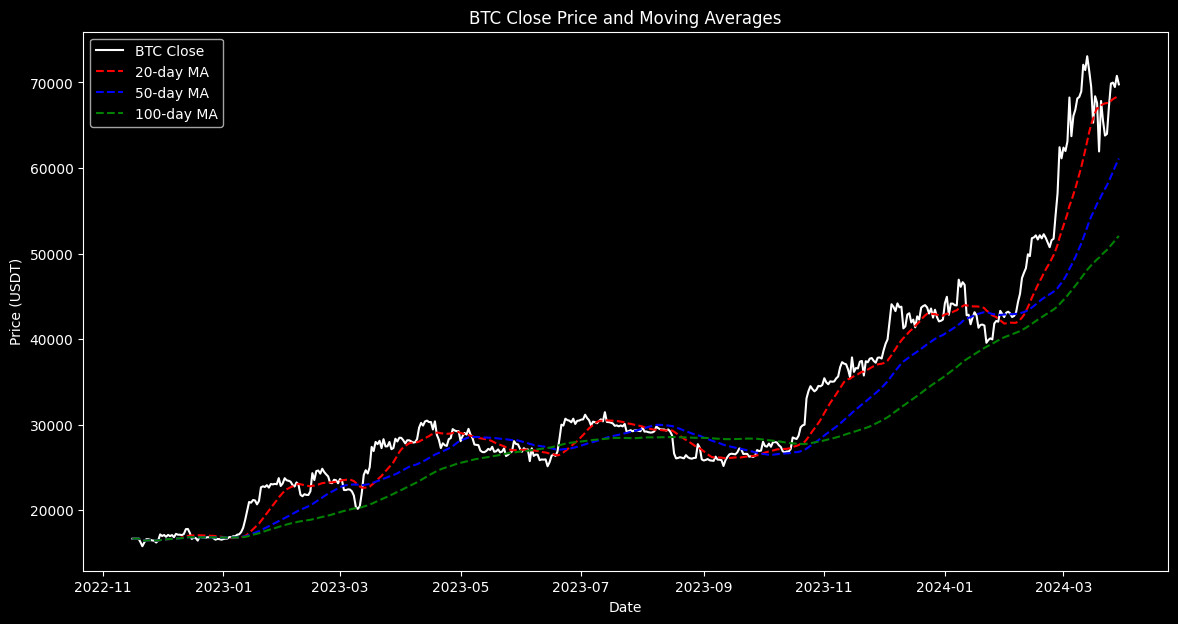

In [6]:
# Define the window sizes for the short, medium, and long term moving averages
short_window = 20
medium_window = 50
long_window = 100

# Calculate the moving averages
df['short_mavg'] = df['close'].rolling(window=short_window, min_periods=1).mean()
df['medium_mavg'] = df['close'].rolling(window=medium_window, min_periods=1).mean()
df['long_mavg'] = df['close'].rolling(window=long_window, min_periods=1).mean()

# Plot the closing price and the moving averages
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='BTC Close', color='white')  # Changed color to white for better visibility on dark background
plt.plot(df.index, df['short_mavg'], label='20-day MA', color='red', linestyle='--')
plt.plot(df.index, df['medium_mavg'], label='50-day MA', color='blue', linestyle='--')
plt.plot(df.index, df['long_mavg'], label='100-day MA', color='green', linestyle='--')

# Add title and labels with a lighter color for better visibility on dark background
plt.title('BTC Close Price and Moving Averages', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price (USDT)', color='white')

# Add legend with a frame to increase readability
plt.legend(frameon=True)

# Show the plot
plt.show()

### Exponential Moving Average

The EMA gives more weight to recent data points, making it more responsive to recent price changes compared to the SMA. The weighting decreases exponentially as you move further back in time.

EMA = K * (Current Price - Previous EMA) + Previous EMA

- where K = 2 / (n + 1)

The 21 Day EMA places a 9 weight on the most recent price, wherease the 100 day EMA only places a 1.9% weight, therefore EMAs calculated overr shorter periods are more responsive to price changes than those calculated over longer periods. 20 and 8 are often used.


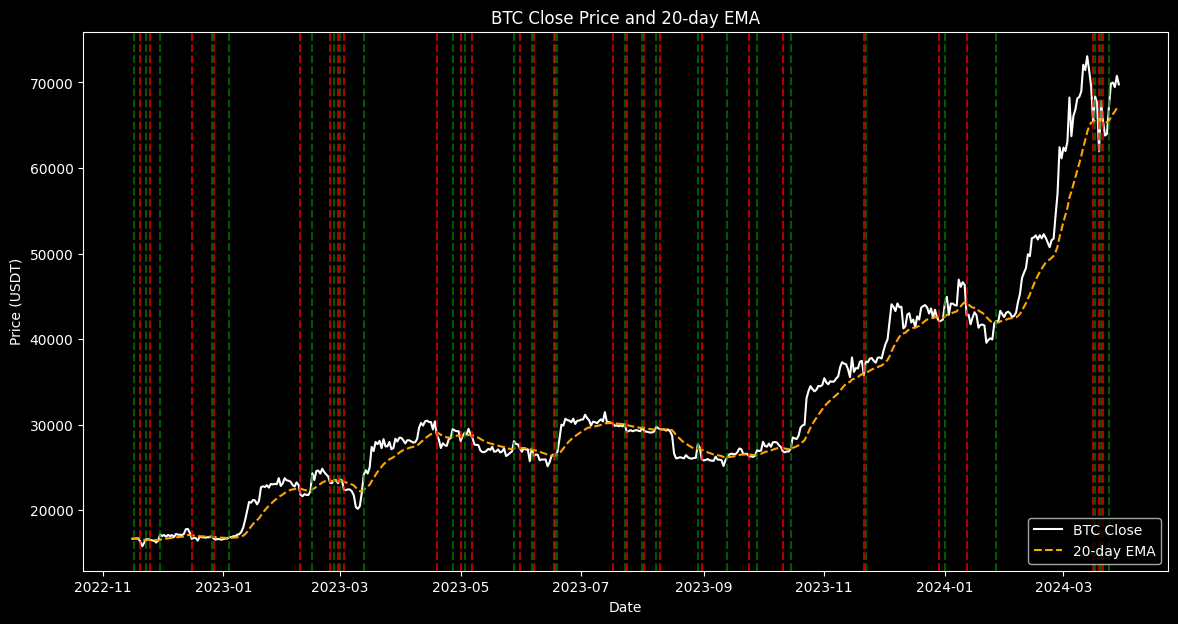

In [7]:
ema_span = 20  # 20-day EMA

# Calculate the EMA using the 'ewm' method and the span defined above
df['ema'] = df['close'].ewm(span=ema_span, adjust=False).mean()

# Identify the points where the closing price crosses the EMA
cross_up = (df['close'] > df['ema']) & (df['close'].shift(1) <= df['ema'].shift(1))
cross_down = (df['close'] < df['ema']) & (df['close'].shift(1) >= df['ema'].shift(1))

# Plot the closing price and the EMA
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='BTC Close', color='white')
plt.plot(df.index, df['ema'], label='20-day EMA', color='orange', linestyle='--')

# Plot vertical lines where the crosses occur
for idx in df[cross_up].index:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.7)
for idx in df[cross_down].index:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7)

# Add title and labels
plt.title('BTC Close Price and 20-day EMA', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price (USDT)', color='white')

# Add legend with a frame to increase readability
plt.legend(frameon=True)

# Show the plot
plt.show()


### Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell - or short - the security when the MACD crosses below the signal line.

The MACD is also often displayed as a histogram, which graphs the distance between the MACD and its signal line. If the MACD is above the signal line, the histogram is above the baseline and vice versa. A bullish crossover occurs when the MACD turns up and crosses above the signal line. A bearish crossover occurs when the MACD turns down and crosses below the signal line.

The formula for the MACD is:

$$ MACD = EMA_{12}(price) - EMA_{26}(price) $$
$$ Signal\ Line = EMA_{9}(MACD) $$
$$ Histogram = MACD - Signal\ Line $$

To use the MACD for trading, you can look for signal line crossovers, centerline crossovers, and divergences. Signal line crossovers are the most common MACD signals. The MACD crossing above the signal line indicates a bullish trend, which suggests it may be time to buy, and the MACD crossing below the signal line indicates a bearish trend, which suggests it may be time to sell.

Now, let's calculate the MACD for the Bitcoin data we have and plot it

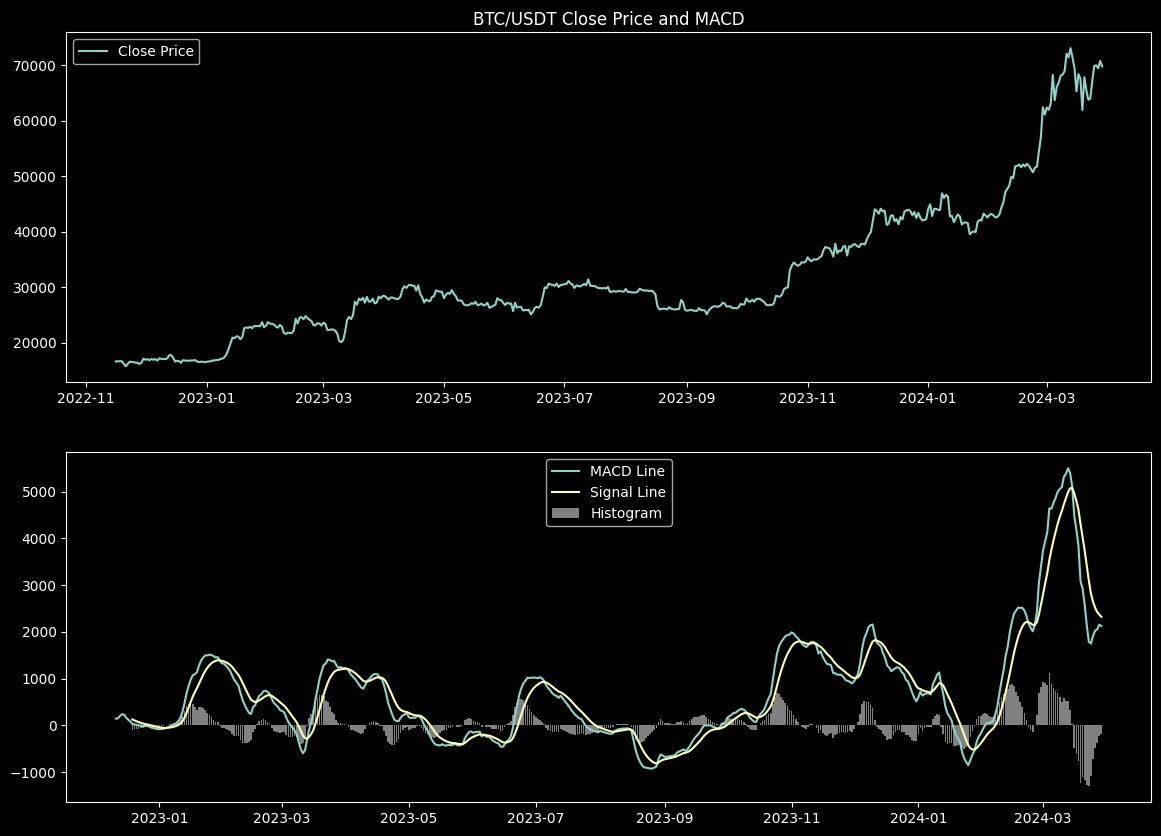

In [8]:
# Calculate MACD
macd_indicator = MACD(df['close'])
df['macd'] = macd_indicator.macd()
df['macd_signal'] = macd_indicator.macd_signal()
df['macd_diff'] = macd_indicator.macd_diff()

# Plot closing price and MACD lines
plt.figure(figsize=(14, 10))

# Plot closing price
plt.subplot(2, 1, 1)
plt.plot(df.index, df['close'], label='Close Price')
plt.title('BTC/USDT Close Price and MACD')
plt.legend()

# Plot MACD
plt.subplot(2, 1, 2)
plt.plot(df.index, df['macd'], label='MACD Line')
plt.plot(df.index, df['macd_signal'], label='Signal Line')
plt.bar(df.index, df['macd_diff'], label='Histogram', color='grey')
plt.legend()

plt.show()

### Average Directional Index (ADX)

The Average Directional Index (ADX) is a technical analysis indicator used to quantify the strength of a trend. The ADX is calculated using a moving average of the expansion of the price range over a certain period of time. It is composed of two other indicators: the Positive Directional Indicator (+DI) and the Negative Directional Indicator (-DI). The ADX is the smoothed average of the absolute value of +DI minus -DI and is represented as a single line with values ranging from 0 to 100.

The ADX is non-directional; it registers trend strength whether price is trending up or down. The indicator is usually plotted in the same window as the two directional movement indicator lines, from which ADX is derived.

Here is how to calculate the ADX:
1. Calculate the True Range (TR), +DI, and -DI for each period.
2. Smooth these periodic values using a moving average, typically over 14 periods.
3. Calculate the DX (Directional Movement Index) which is (+DI minus -DI) divided by (+DI plus -DI), all absolute values.
4. The ADX is then a moving average of the DX values.

- 0-25: Indicates a weak or non-existent trend. Traders may consider staying out of the market or using range-bound strategies.

- 25-50: Suggests a moderate trend is in place. Traders may consider trend-following strategies and look for opportunities to enter trades in the direction of the trend.

- 50-75: Indicates a strong trend. Traders may look for pullbacks or retracements to enter trades in the direction of the trend.

- 75-100: Suggests an extremely strong trend. Traders may consider taking profits on existing positions or tightening stop-loss levels.

To plot the ADX, we will use the `ADXIndicator` class from the `ta` library, which requires the high, low, and close prices. We will then plot the ADX using matplotlib.

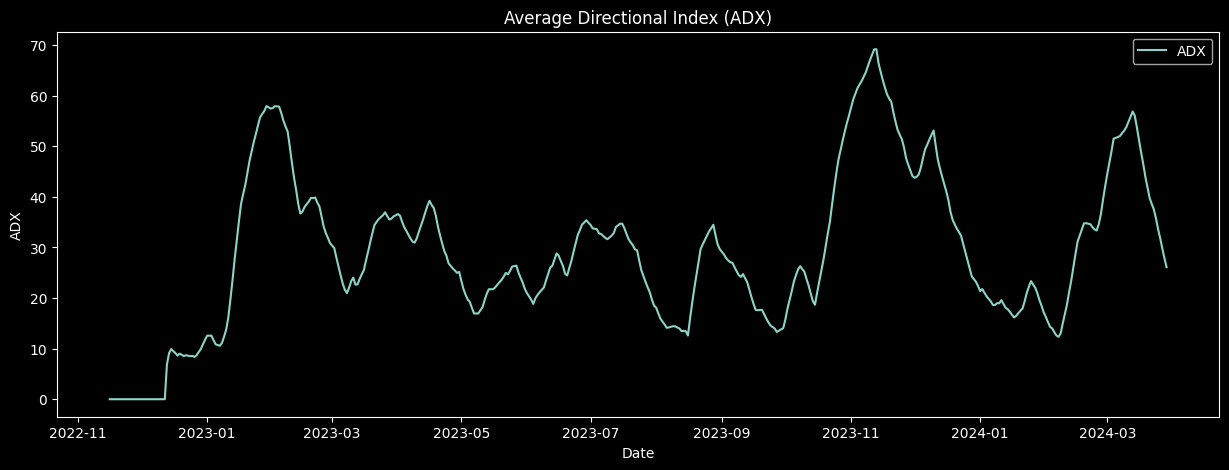

In [9]:
# Calculate the ADX using the ta library
adx_indicator = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14, fillna=False)
df['adx'] = adx_indicator.adx()

# Plotting the ADX
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['adx'], label='ADX')
plt.title('Average Directional Index (ADX)')
plt.xlabel('Date')
plt.ylabel('ADX')
plt.legend()
plt.show()

### Aroon Indicator

The Aroon indicator is a technical analysis tool used to identify trends in the price of an asset and the likelihood of the trend continuing. It consists of two lines: Aroon Up and Aroon Down. Aroon Up measures the strength of the uptrend, while Aroon Down measures the strength of the downtrend. The indicator is based on the premise that a stock's price will close at record highs in an uptrend and record lows in a downtrend.

The Aroon Up and Down are calculated as follows:
- Aroon Up = ((number of periods) - (number of periods since highest high)) / (number of periods) * 100
- Aroon Down = ((number of periods) - (number of periods since lowest low)) / (number of periods) * 100

Typically, a period of 25 days is used for calculation. When the Aroon Up is above the Aroon Down, it indicates bullish momentum, and when the Aroon Down is above the Aroon Up, it indicates bearish momentum. Crossovers of these lines can signal potential trend changes.

To use the Aroon indicator in trading, one might consider buying when the Aroon Up crosses above the Aroon Down, especially if it is above the 50 level, indicating a strong uptrend. Conversely, one might consider selling when the Aroon Down crosses above the Aroon Up, especially if it is above the 50 level, indicating a strong downtrend.

Now, let's calculate the Aroon indicator for the existing DataFrame `df` and plot it

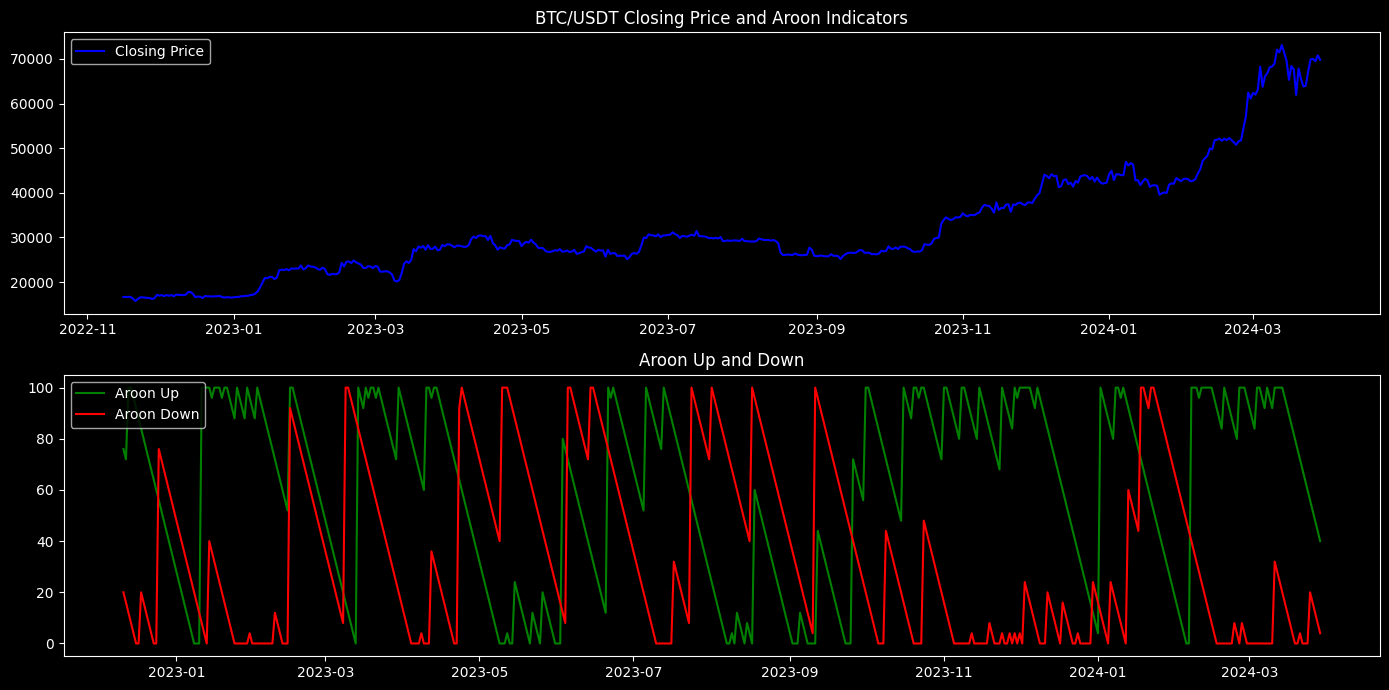

In [10]:
aroon_indicator = AroonIndicator(high=df['high'], low=df['low'], window=25)
df['aroon_up'] = aroon_indicator.aroon_up()
df['aroon_down'] = aroon_indicator.aroon_down()

# Plot the closing price and the Aroon indicators
plt.figure(figsize=(14, 7))

# Plot closing price
plt.subplot(211)
plt.plot(df['close'], label='Closing Price', color='blue')  # Changed color from 'white' to 'blue' for visibility
plt.title('BTC/USDT Closing Price and Aroon Indicators')
plt.legend(loc='upper left')

# Plot Aroon Up and Aroon Down
plt.subplot(212)
plt.plot(df['aroon_up'], label='Aroon Up', color='green')
plt.plot(df['aroon_down'], label='Aroon Down', color='red')
plt.title('Aroon Up and Down')
plt.legend(loc='upper left')

plt.tight_layout()

### Ichimoku Cloud

The Ichimoku Cloud, also known as Ichimoku Kinko Hyo, is a versatile indicator that defines support and resistance, identifies trend direction, gauges momentum, and provides trading signals. It is composed of five lines, each representing different time intervals:

1. Tenkan-sen (Conversion Line): (9-period high + 9-period low) / 2
2. Kijun-sen (Base Line): (26-period high + 26-period low) / 2
3. Senkou Span A (Leading Span A): (Tenkan-sen + Kijun-sen) / 2, plotted 26 periods ahead
4. Senkou Span B (Leading Span B): (52-period high + 52-period low) / 2, plotted 26 periods ahead
5. Chikou Span (Lagging Span): Current closing price plotted 26 periods behind

The space between Senkou Span A and Senkou Span B forms the "cloud" (Kumo), which can help determine the strength of the trend. A bullish signal is given when the price is above the cloud, while a bearish signal is when the price is below the cloud. The cloud also changes color, giving a visual representation of the market sentiment.

To interpret the Ichimoku Cloud:
- When the price is above the cloud, the trend is up.
- When the price is below the cloud, the trend is down.
- When the price is in the cloud, the market is in a range or the trend is losing its momentum.

The crossover of the Tenkan-sen and Kijun-sen can also be used as a trading signal, similar to a moving average crossover.

Next, we will calculate the Ichimoku Cloud for the given DataFrame and plot it to visualize the trend and potential support and resistance levels.

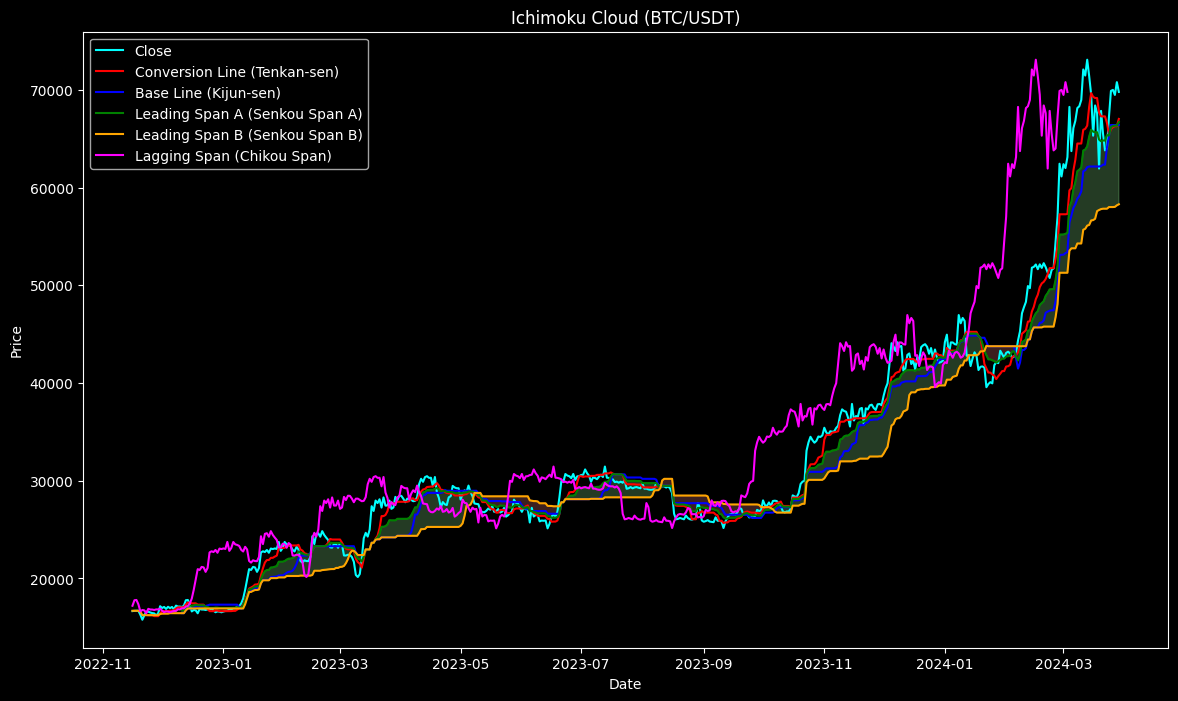

In [11]:
# Calculate Ichimoku Cloud
ichimoku = IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52, visual=False)
df['ichimoku_conversion_line'] = ichimoku.ichimoku_conversion_line()
df['ichimoku_base_line'] = ichimoku.ichimoku_base_line()
df['ichimoku_leading_span_a'] = ichimoku.ichimoku_a()
df['ichimoku_leading_span_b'] = ichimoku.ichimoku_b()
df['ichimoku_lagging_span'] = df['close'].shift(-26)  # Shifted 26 periods back

# Plot the Ichimoku Cloud
plt.figure(figsize=(14, 8))

# Plot closing prices
plt.plot(df.index, df['close'], label='Close', color='cyan')

# Plot Ichimoku lines
plt.plot(df.index, df['ichimoku_conversion_line'], label='Conversion Line (Tenkan-sen)', color='red')
plt.plot(df.index, df['ichimoku_base_line'], label='Base Line (Kijun-sen)', color='blue')
plt.plot(df.index, df['ichimoku_leading_span_a'], label='Leading Span A (Senkou Span A)', color='green')
plt.plot(df.index, df['ichimoku_leading_span_b'], label='Leading Span B (Senkou Span B)', color='orange')

# Plot the cloud
plt.fill_between(df.index, df['ichimoku_leading_span_a'], df['ichimoku_leading_span_b'], where=df['ichimoku_leading_span_a'] >= df['ichimoku_leading_span_b'], color='lightgreen', alpha=0.25)
plt.fill_between(df.index, df['ichimoku_leading_span_a'], df['ichimoku_leading_span_b'], where=df['ichimoku_leading_span_a'] < df['ichimoku_leading_span_b'], color='lightcoral', alpha=0.25)

# Plot the lagging span
plt.plot(df.index, df['ichimoku_lagging_span'], label='Lagging Span (Chikou Span)', color='magenta')

# Enhance the plot
plt.title('Ichimoku Cloud (BTC/USDT)')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Parabolic Stop and Reverse (SAR)

The Parabolic SAR (Stop and Reverse) is a technical analysis indicator used to determine the direction of a security's momentum and the point at which this momentum has a higher-than-normal probability of switching directions. SAR stands for "stop and reverse," which is the actual indicator used in the calculation.

To calculate the Parabolic SAR, you follow these steps:

1. Choose an initial SAR value. This is typically the highest high or the lowest low of the previous period.
2. Determine the initial extreme point (EP), which is the highest high or the lowest low of the current trend.
3. Calculate the acceleration factor (AF), which starts at 0.02 and increases by 0.02 each time a new EP is established, up to a maximum of 0.20.
4. For each new period, calculate the SAR as follows:
   - If the trend is up, SAR = SAR_previous + AF * (EP_previous - SAR_previous)
   - If the trend is down, SAR = SAR_previous - AF * (EP_previous - SAR_previous)
5. If the next period's SAR is within or beyond the current or previous period's price range, adjust it to the closest price bound.

The Parabolic SAR is plotted as a series of dots above or below the price bars. A dot below the price is considered bullish, and a dot above is bearish. A change in the position of the dots suggests that a change in trend may be happening.

Now, let's calculate the Parabolic SAR for our DataFrame and plot it along with the closing price.

c:\Users\markw\Desktop\atlas\atlas_notebook\venv\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


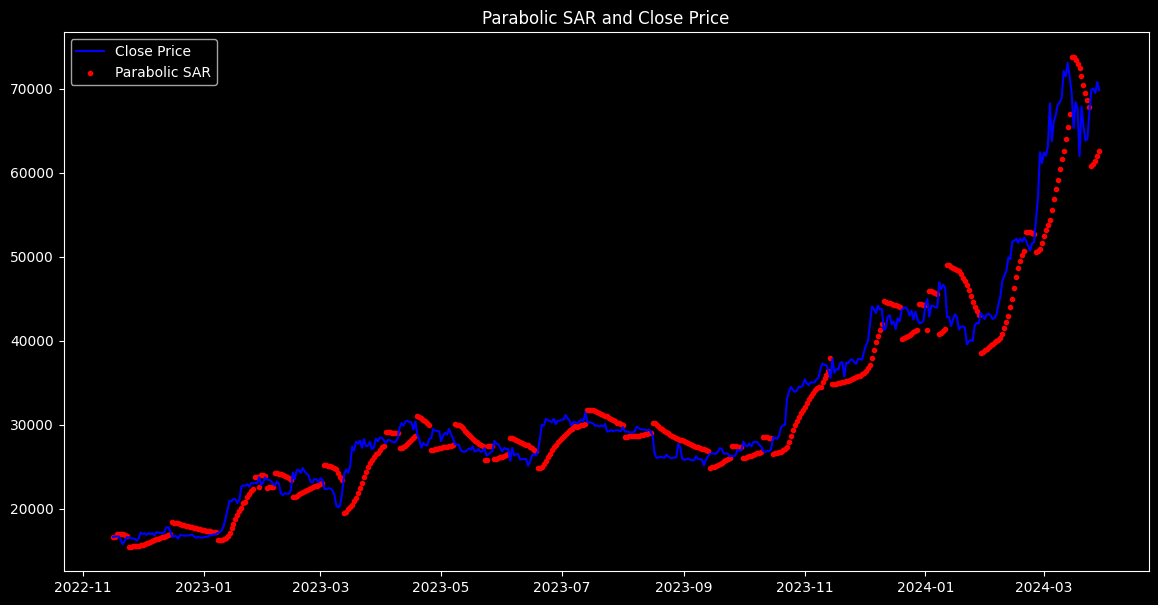

In [12]:
psar_indicator = PSARIndicator(df['high'], df['low'], df['close'], step=0.02, max_step=0.2)

# Add Parabolic SAR values to the DataFrame
df['psar'] = psar_indicator.psar()

# Plot the closing prices and the Parabolic SAR
plt.figure(figsize=(14, 7))
plt.plot(df['close'], label='Close Price', color='blue')
plt.scatter(df.index, df['psar'], label='Parabolic SAR', color='red', marker='.')
plt.title('Parabolic SAR and Close Price')
plt.legend()

plt.show()

---

## Volatility Indicators


Volatility indicators in technical analysis help traders gauge the magnitude of price fluctuations in financial markets over a given period. They provide insights into market sentiment, potential trend reversals, and risk management strategies.

### Bollinger Bands

Bollinger Bands are a type of price envelope developed by John Bollinger. They consist of three lines:

1. The middle band, which is a simple moving average (SMA) of the closing prices.
2. The upper band, which is the SMA plus a specified number of standard deviations (usually two).
3. The lower band, which is the SMA minus the same number of standard deviations.

The standard deviation is a measure of volatility, so the bands adjust themselves to current market conditions. When the bands are far apart, market volatility is high, and when they are close together, volatility is low.

The values of Bollinger Bands can be interpreted in several ways:

- **Price touching or crossing the upper band** may indicate that the asset is overbought, and a price pullback may be imminent.
- **Price touching or crossing the lower band** may suggest that the asset is oversold, and a price bounce could occur.
- **A tight "squeeze"** of the bands (both bands close to the middle band) can signal a period of low volatility and potentially the start of a new market move as volatility increases.

To calculate Bollinger Bands, you can use the `BollingerBands` class from the `ta` (technical analysis) library, which you have already imported. You will need to specify the window size for the moving average and the number of standard deviations for the bands.

Let's calculate the Bollinger Bands for the Bitcoin data you have and plot them along with the closing price

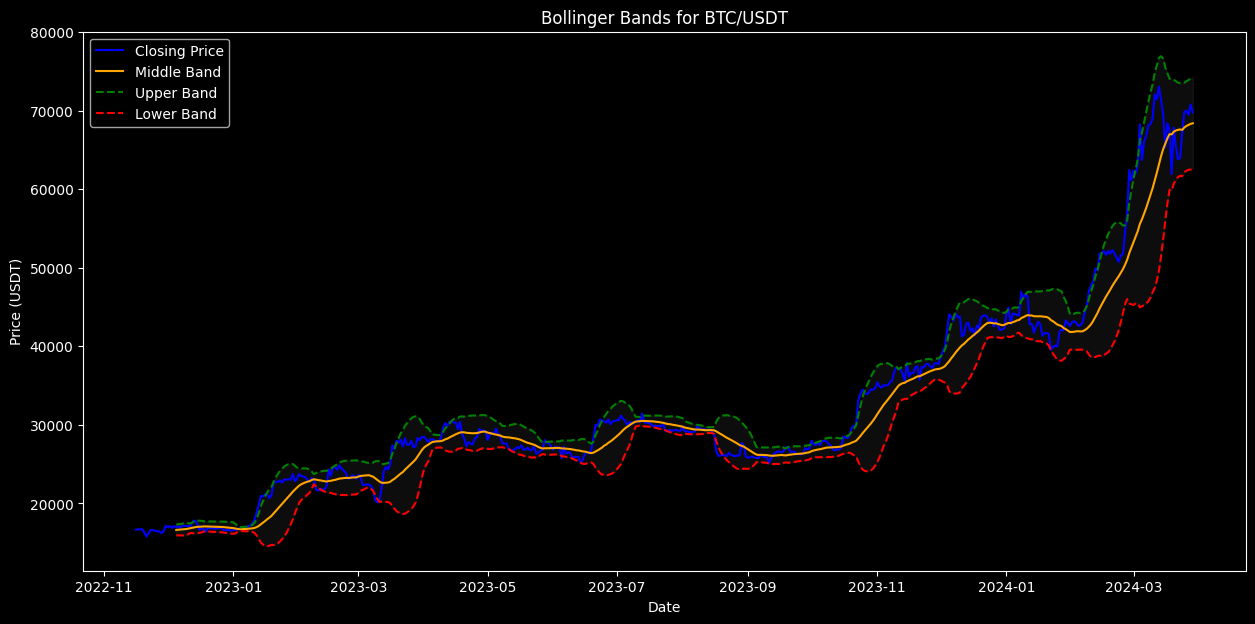

In [13]:
# Define the window size and the number of standard deviations
window = 20
no_of_stds = 2

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df['close'], window=window, window_dev=no_of_stds)

# Add Bollinger Bands features to the DataFrame
df['bb_mavg'] = indicator_bb.bollinger_mavg()  # Middle Band
df['bb_hband'] = indicator_bb.bollinger_hband()  # Upper Band
df['bb_lband'] = indicator_bb.bollinger_lband()  # Lower Band

# Plot the closing price and Bollinger Bands
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close'], label='Closing Price', color='blue')
plt.plot(df.index, df['bb_mavg'], label='Middle Band', color='orange')
plt.plot(df.index, df['bb_hband'], label='Upper Band', linestyle='--', color='green')
plt.plot(df.index, df['bb_lband'], label='Lower Band', linestyle='--', color='red')

# Fill the area between the Bollinger Bands
plt.fill_between(df.index, df['bb_lband'], df['bb_hband'], color='grey', alpha=0.1)

# Add title and labels
plt.title('Bollinger Bands for BTC/USDT')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')

# Show legend
plt.legend()

# Display the plot
plt.show()

### Average True Range

 Average True Range (ATR) is a technical analysis indicator that measures market volatility by decomposing the entire range of an asset price for that period. Specifically, it is the average of the true ranges over a specified period. The true range extends the concept of range to include the previous closing price if it was outside of the current high to low range.

The true range is the largest of the following three values:
1. Current High less the current Low
2. Absolute value of the current High less the previous Close
3. Absolute value of the current Low less the previous Close

The ATR is then a moving average, generally using the same period length as the true ranges.

To interpret the ATR, traders may look at higher values as an indication of high volatility, which may signal a trend change or market uncertainty. Lower ATR values are often associated with a lack of market interest and consolidation.

To calculate the ATR using the `ta` library, you can use the `AverageTrueRange` class, which requires the high, low, and close columns of the DataFrame. Once calculated, you can plot the ATR to visualize volatility over time.

Let's calculate the ATR for our DataFrame and plot it

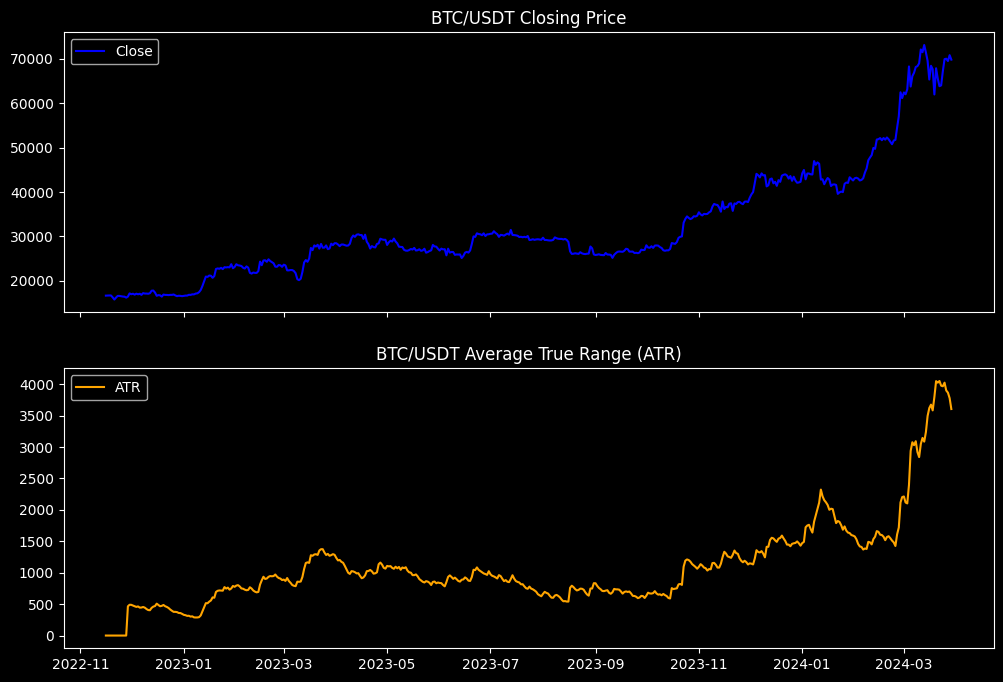

In [14]:

# Initialize the AverageTrueRange class with a typical period of 14 days
atr_period = 14
atr_indicator = AverageTrueRange(df['high'], df['low'], df['close'], window=atr_period)

# Calculate the ATR
df['atr'] = atr_indicator.average_true_range()

# Plot the closing price and ATR
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot the closing price
ax1.set_title(f'{symbol} Closing Price')
ax1.plot(df.index, df['close'], label='Close', color='blue')
ax1.legend(loc='upper left')

# Plot the ATR
ax2.set_title(f'{symbol} Average True Range (ATR)')
ax2.plot(df.index, df['atr'], label='ATR', color='orange')
ax2.legend(loc='upper left')

# Show the plot
plt.show()


### Donchian Channel

The Donchian channel is a technical indicator used in market trading developed by Richard Donchian. It consists of three lines, which are calculated as follows:

- The "upper band" is the highest price of an asset over a set period of time.
- The "lower band" is the lowest price of an asset over the same period of time.
- The "middle band" is the average of the upper and lower bands.

The Donchian channel is used to identify breakout points in the market. When the price of an asset breaks through the upper band, it may indicate a buying opportunity as it suggests an upward trend. Conversely, if the price breaks below the lower band, it may suggest a selling opportunity as it indicates a downward trend.

The period used to calculate the Donchian channel can be adjusted depending on the trader's strategy, with 20 periods being a common choice.

To interpret the Donchian channel:

- A price move to the upper band can signal the start of a new uptrend.
- A price move to the lower band can indicate the start of a new downtrend.
- The middle band can serve as an average price line, which can act as a support or resistance level.

Now, let's calculate the Donchian channel for the given DataFrame `df` and plot it.

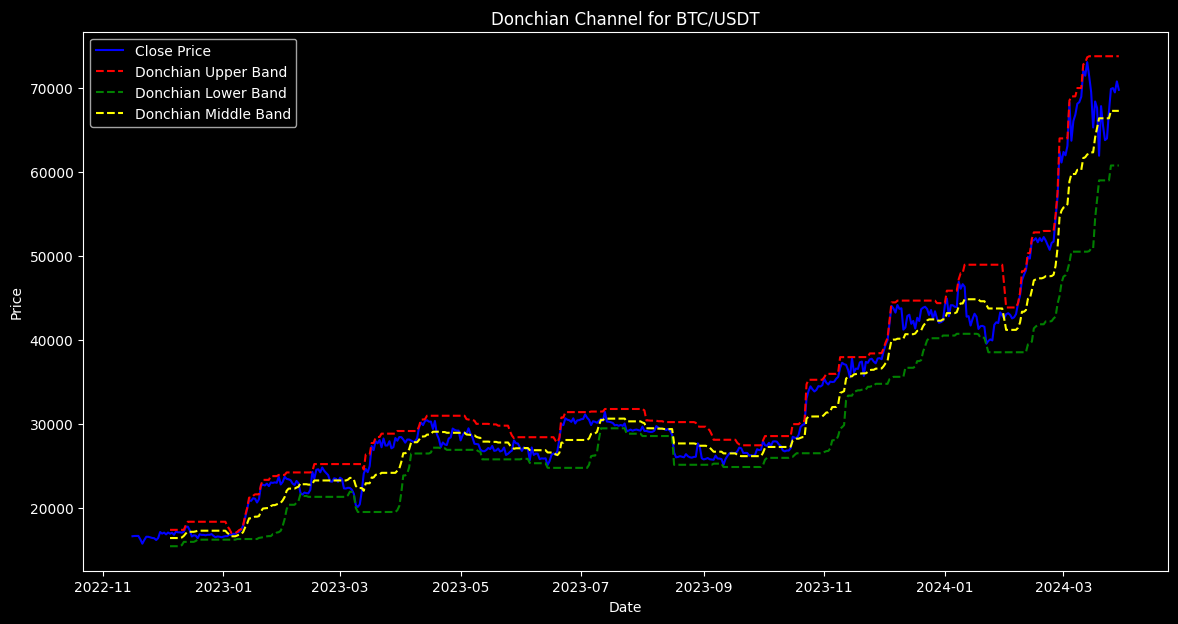

In [15]:
# Define the period for the Donchian channel
donchian_period = 20

# Calculate the upper band as the rolling max of the high prices
df['donchian_upper'] = df['high'].rolling(window=donchian_period).max()

# Calculate the lower band as the rolling min of the low prices
df['donchian_lower'] = df['low'].rolling(window=donchian_period).min()

# Calculate the middle band as the average of the upper and lower bands
df['donchian_middle'] = (df['donchian_upper'] + df['donchian_lower']) / 2

# Plot the closing price and the Donchian channels
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['donchian_upper'], label='Donchian Upper Band', linestyle='--', color='red')
plt.plot(df.index, df['donchian_lower'], label='Donchian Lower Band', linestyle='--', color='green')
plt.plot(df.index, df['donchian_middle'], label='Donchian Middle Band', linestyle='--', color='yellow')

plt.title(f"Donchian Channel for {symbol}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Momentum Indicators

Momentum indicators measure the rate of change in price movements over a specific period. They help traders identify the strength or weakness of a trend, as well as potential trend reversals.

These indicators can signal whether an asset is overbought or oversold, which can be used to anticipate potential corrections or reversals in price.


### Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. It is used to identify overbought or oversold conditions in the trading of an asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.

The RSI is calculated using the following steps:
1. Calculate the average gain and average loss over a specified period (typically 14 periods).
2. Compute the relative strength (RS) which is the ratio of average gain to average loss.
3. The RSI is then calculated using the formula: RSI = 100 - (100 / (1 + RS)).

 Interpretation:
- An RSI above 70 is typically considered overbought, suggesting that the asset may be getting overvalued and could be primed for a trend reversal or corrective pullback in price.
- An RSI below 30 is typically considered oversold, indicating that the asset may be undervalued and could be due for a bounce back.

Plotting RSI:
To visualize the RSI, traders often plot it below the price chart with marked levels at 30 and 70 to identify the overbought and oversold conditions.


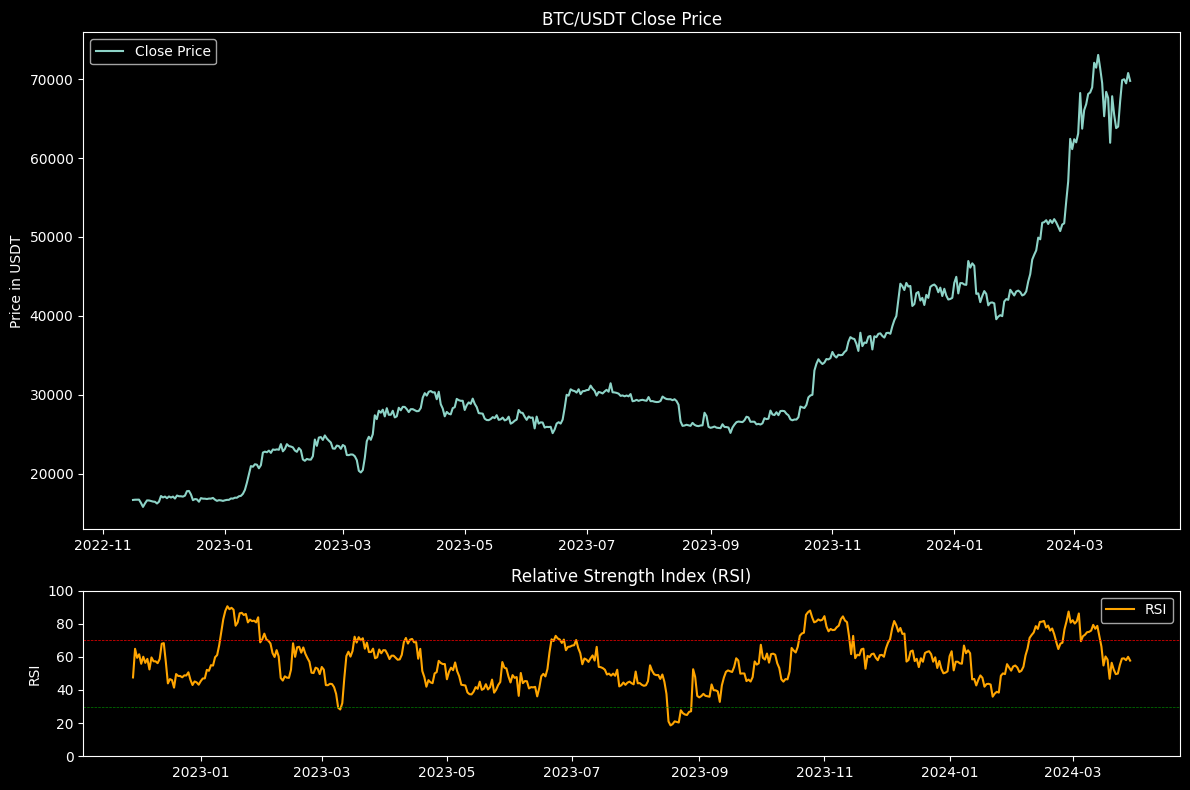

In [16]:
# Calculate the RSI
rsi_period = 14  # Typically, a 14-period RSI is used
rsi_indicator = RSIIndicator(df['close'], rsi_period)
df['rsi'] = rsi_indicator.rsi()

# Plotting the price and RSI charts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot the closing price
ax1.plot(df.index, df['close'], label='Close Price')
ax1.set_title('BTC/USDT Close Price')
ax1.set_ylabel('Price in USDT')
ax1.legend()

# Plot the RSI
ax2.plot(df.index, df['rsi'], label='RSI', color='orange')
ax2.axhline(70, color='red', linestyle='--', linewidth=0.5)
ax2.axhline(30, color='green', linestyle='--', linewidth=0.5)
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])  # RSI ranges from 0 to 100
ax2.legend()

plt.tight_layout()

### Stochastic Oscillator

Sochastic Oscillator is a momentum indicator that compares a particular closing price of an asset to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result.

The Stochastic Oscillator is calculated using the following formula:

%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K

Where:
- Current Close is the most recent closing price.
- Lowest Low is the lowest price traded of the security or commodity during the look-back period.
- Highest High is the highest price traded during the look-back period.
- %K is known as the fast stochastic indicator.
- %D is the 3-day simple moving average of %K and is known as the slow stochastic indicator.

The look-back period is typically set to 14 periods, which can be in minutes, days, weeks, or months.

The Stochastic Oscillator values range from 0 to 100. Values above 80 indicate that the asset is overbought, while values below 20 indicate that the asset is oversold. These levels can be adjusted to better fit the security or analytical requirements.

Traders often look for divergences between the Stochastic Oscillator and the price of the asset. For example, if the price makes a new high but the oscillator does not, it may suggest the momentum is waning.

Now, let's calculate the Stochastic Oscillator for the given DataFrame `df` and plot# Define the period for the Stochastic Oscillator

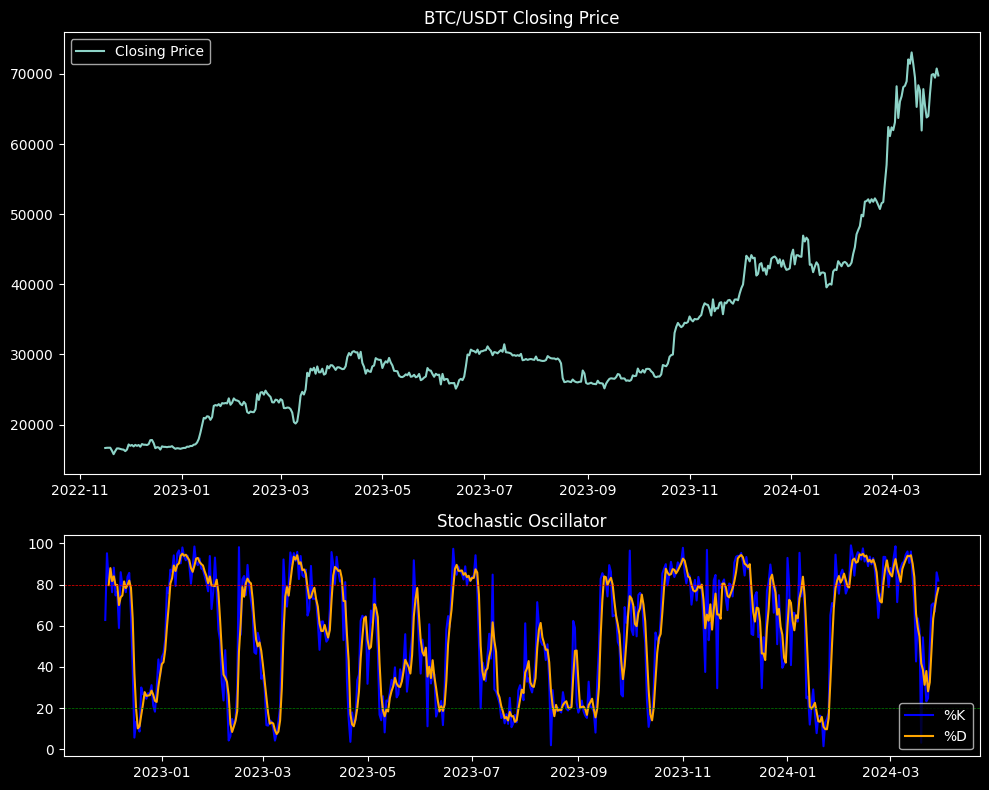

In [17]:
stoch_window = 14
stoch_smooth_window = 3

# Initialize the Stochastic Oscillator
stoch = StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=stoch_window, smooth_window=stoch_smooth_window)

# Calculate %K and %D for the Stochastic Oscillator
df['stoch_%K'] = stoch.stoch()
df['stoch_%D'] = stoch.stoch_signal()

# Plot the closing price and the Stochastic Oscillator
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# Plot the closing price
axes[0].plot(df.index, df['close'], label='Closing Price')
axes[0].set_title('BTC/USDT Closing Price')
axes[0].legend()

# Plot the Stochastic Oscillator
axes[1].plot(df.index, df['stoch_%K'], label='%K', color='blue')
axes[1].plot(df.index, df['stoch_%D'], label='%D', color='orange')
axes[1].axhline(80, color='red', linestyle='--', linewidth=0.5)
axes[1].axhline(20, color='green', linestyle='--', linewidth=0.5)
axes[1].set_title('Stochastic Oscillator')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

---

## Volume Indicators

Volume indicators in technical analysis help traders analyze the trading volume associated with price movements in financial markets. 
They provide insights into the strength and sustainability of price trends, potential trend reversals, and the overall market sentiment

### Volume Weighted Average Price

VWAP, or Volume Weighted Average Price, is a trading benchmark that is often used to determine the average price a security has traded at throughout the day, based on both volume and price. It is a measure of the average price at which a crypto/stock is traded over the trading horizon.

To calculate VWAP, you follow these steps:
1. Multiply the typical price for each period by the volume for that period. The typical price is calculated as (High + Low + Close)/3.
2. Keep a running total of these values (cumulative total).
3. Keep a running total of volume (cumulative volume).
4. Divide the cumulative total by the cumulative volume.

The value of VWAP gives traders insight into both the trend and value of a security. A price below the VWAP could indicate that a security is "cheap" or at a lower value in the context of the day's action, while a price above the VWAP could indicate that a security is "expensive" on the day.

Interpreting VWAP:
- If the price is above VWAP, it may be considered a good time to sell.
- If the price is below VWAP, it may be considered a good time to buy.

Let's calculate the VWAP for our DataFrame and plot it along with the closing price

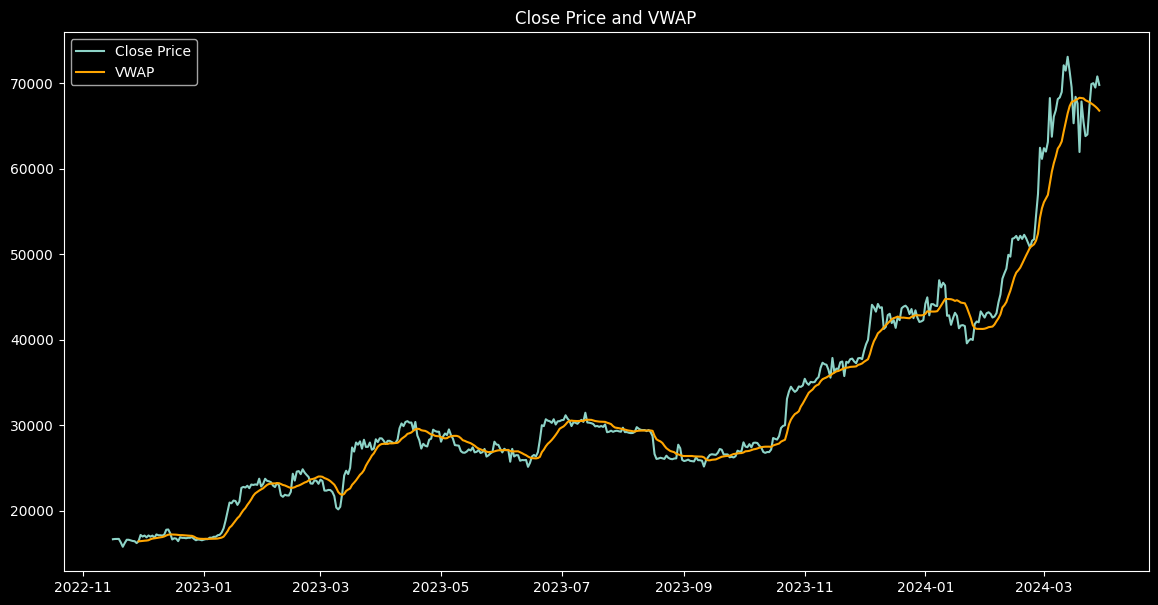

In [18]:
vwap_indicator = VolumeWeightedAveragePrice(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14)

# Calculate the VWAP
df['vwap'] = vwap_indicator.volume_weighted_average_price()

# Plot the closing price and the VWAP
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price')
plt.plot(df.index, df['vwap'], label='VWAP', color='orange')
plt.title('Close Price and VWAP')
plt.legend()
plt.show()


### On Balance Volume (OBV)

-Balance Volume (OBV) is a technical trading momentum indicator that uses volume flow to predict changes in stock price. The theory behind OBV is based on the distinction between smart money – namely, institutional investors – and less sophisticated retail investors. As such, OBV assumes that smart money can be seen flowing into the security by a rising volume when the price increases, and out of the security by a falling volume when the price decreases.

The calculation of OBV is relatively straightforward. It involves a cumulative total of volume:

- If the closing price is above the prior close price, then: Current OBV = Previous OBV + Current Volume
- If the closing price is below the prior close price, then: Current OBV = Previous OBV - Current Volume
- If the closing prices are equal, then: Current OBV = Previous OBV

The values of OBV can be any positive or negative integer depending on the starting point. Since it is a cumulative measure, its absolute value is not as important as its direction or the changes over time.

Interpreting OBV is based on the general principle that the volume precedes the price. Therefore, if OBV is rising, it is generally taken to mean that the volume is supporting the price movements upwards, which is bullish. Conversely, if OBV is falling, the volume is supporting price movements downwards, which is bearish.

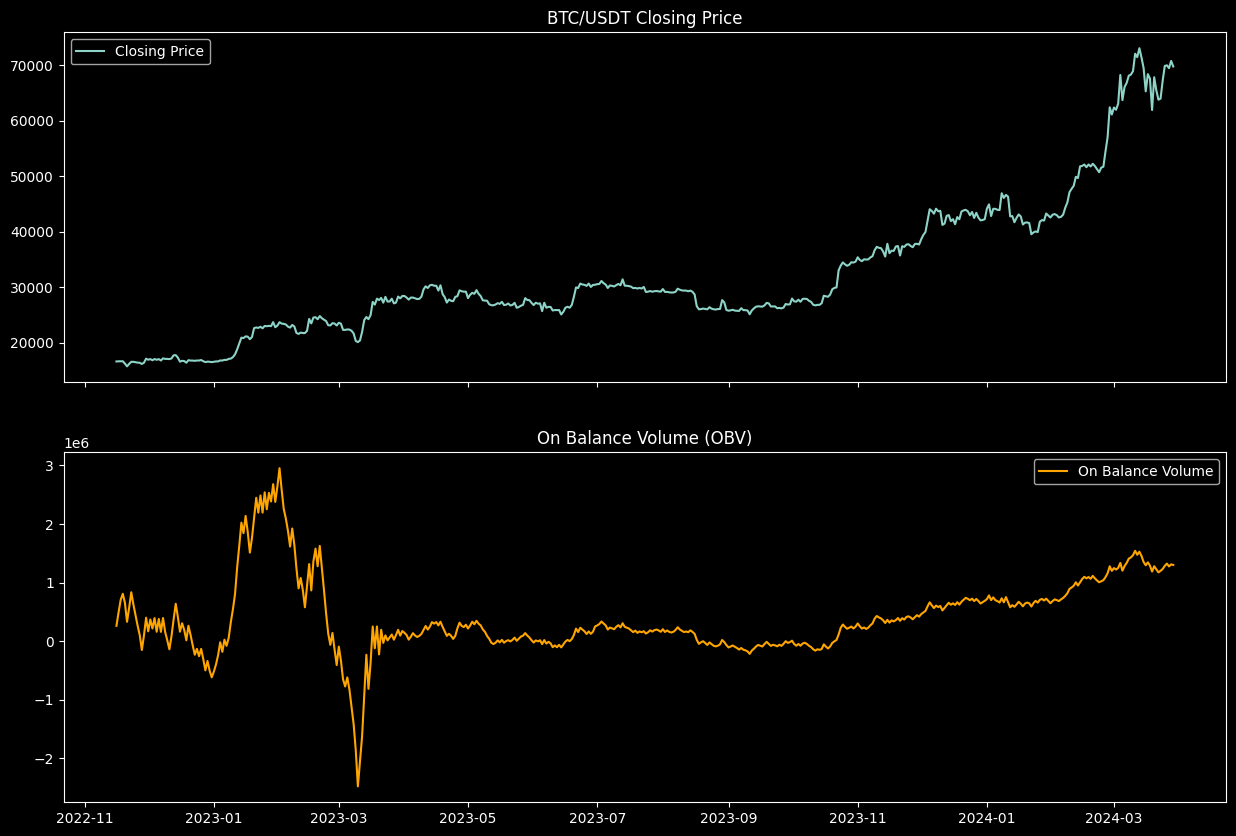

In [19]:
# Initialize OnBalanceVolumeIndicator
obv_indicator = OnBalanceVolumeIndicator(df['close'], df['volume'])

# Calculate On Balance Volume
df['obv'] = obv_indicator.on_balance_volume()

# Plotting the OBV with the closing price
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot closing price on ax1
ax1.plot(df.index, df['close'], label='Closing Price')
ax1.set_title('BTC/USDT Closing Price')
ax1.legend()

# Plot OBV on ax2
ax2.plot(df.index, df['obv'], label='On Balance Volume', color='orange')
ax2.set_title('On Balance Volume (OBV)')
ax2.legend()

# Show the plot
plt.show()

### Accumulation/Distribution Index (ADI) 

The Accumulation/Distribution Index (ADI) is a volume-based indicator designed to measure the cumulative flow of money into and out of a security. It was developed by Marc Chaikin. The ADI is calculated by taking a volume multiplier based on the relationship between the close and the high-low range for a given period, multiplying this value by the period's volume, and then cumulatively summing this value.

The formula for the ADI is as follows:

`ADI = ADI_prev + ((Close - Low) - (High - Close)) / (High - Low) * Volume`

Where:
- `ADI_prev` is the previous period's ADI value.
- `Close` is the closing price for the period.
- `High` is the highest price for the period.
- `Low` is the lowest price for the period.
- `Volume` is the volume for the period.

The ADI can take any real number value, and its interpretation is as follows:
- A rising ADI suggests accumulation and is considered bullish.
- A falling ADI suggests distribution and is considered bearish.
- Divergences between the ADI and price action can indicate potential reversals.

Now, let's calculate the ADI for our DataFrame and plot it

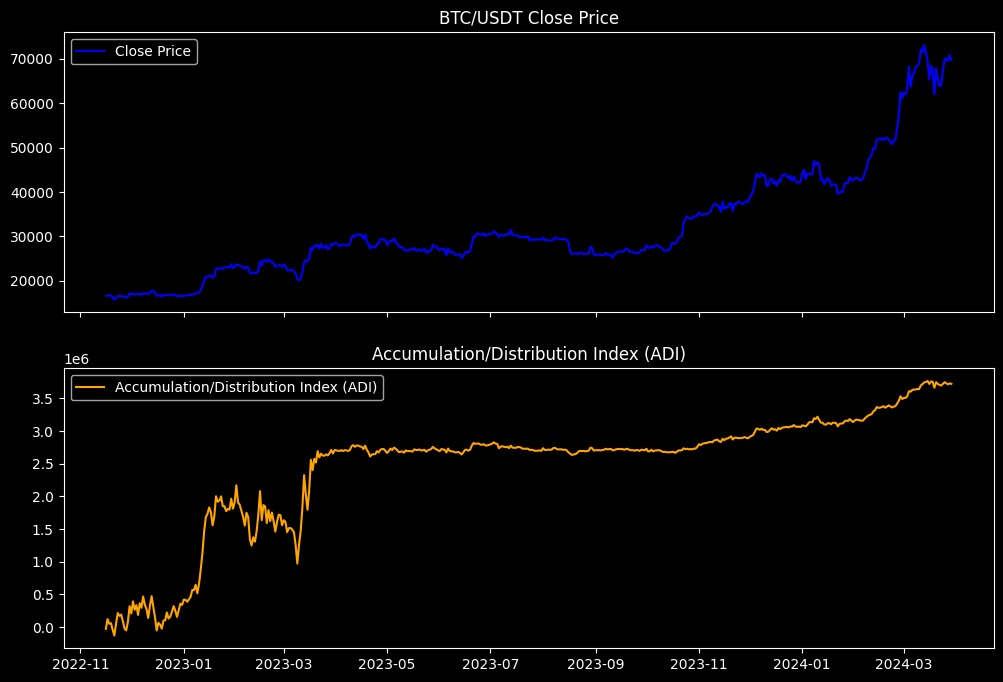

In [20]:
# Calculate the Accumulation/Distribution Index (ADI)
adi_indicator = AccDistIndexIndicator(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'])
df['adi'] = adi_indicator.acc_dist_index()

# Plot the closing price and the ADI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the closing price
ax1.plot(df.index, df['close'], label='Close Price', color='blue')
ax1.set_title('BTC/USDT Close Price')
ax1.legend(loc='upper left')

# Plot the ADI
ax2.plot(df.index, df['adi'], label='Accumulation/Distribution Index (ADI)', color='orange')
ax2.set_title('Accumulation/Distribution Index (ADI)')
ax2.legend(loc='upper left')

# Show the plot
plt.show()